In [3]:
# %%
# Linalg imports
import jax.numpy as np
import numpy as onp
from jax import random
from jax import jit
from jax import lax
import argparse
# Jax MD imports
from jax_md import space, smap, energy, minimize, quantity, simulate

# Helper imports
from rich.progress import track

# Plotting imports
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import bottleneck as bn
import pandas as pd


import jax
import socket
print(socket.gethostname())

sheep


0it [00:00, ?it/s]/tmp/ipykernel_3446700/2718258027.py:55: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  initial_positions = random.uniform(
3it [04:05, 81.75s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


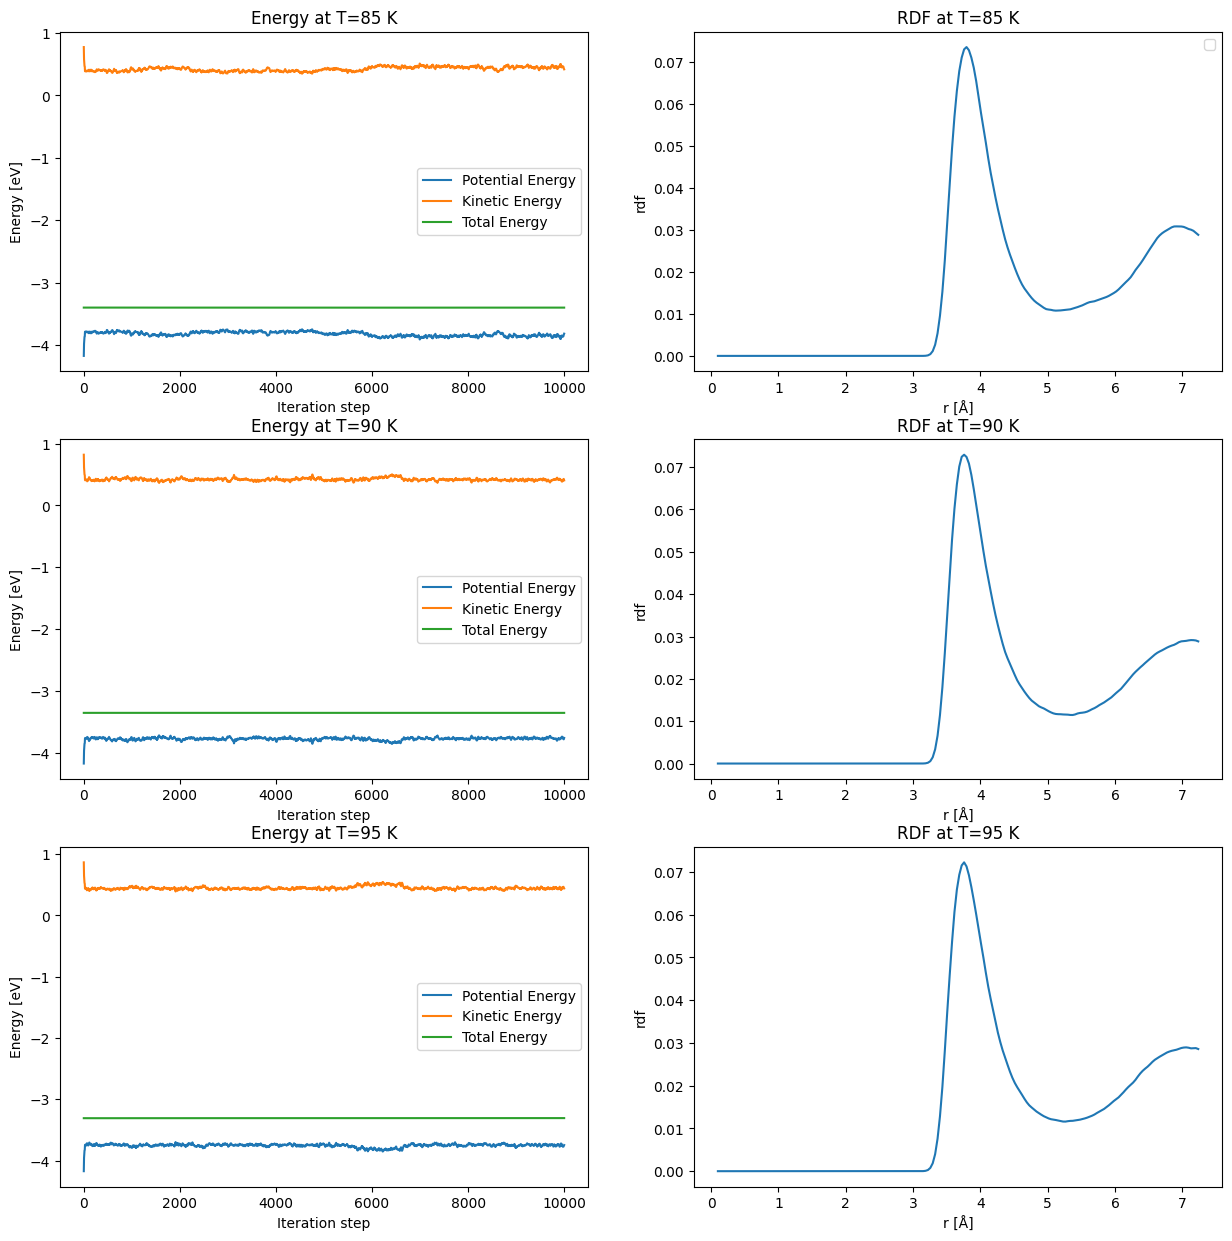

In [6]:

# Parameters to correctly instantiate the simulation box.
rho_argon = 1.40  # g/cm³
mass_argon = 39.95  # g/mol
avogadro = 6.022e23  # atoms/mol
kb = 8.617e-5  # Boltzmann constant

# Calculate number density in atoms/cm³
n_argon = (rho_argon * avogadro) / mass_argon

# Continuing from the previous calculation
n_argon_cm3 = n_argon  # This is in atoms/cm³

# Conversion factor from cm³ to Å³
conversion_factor = 1e24  # (10^8)^3

# Convert number density to atoms/Å³ for use in simulations
n_argon_A3 = n_argon_cm3 / conversion_factor


# Get the initial conditions of the simulation
n_particles = 64
dimension = 3
temperature_list = [85,90,95]  # In Kelvin
dt=0.1  # Time step

# Compute the box size
box_size = quantity.box_size_at_number_density(n_particles, n_argon_A3, dimension)
@jax.jit
def vacf(velocity):
        """
        Compute the velocity autocorrelation function.

        Parameters
        ----------
        velocity 
            The velocity of the particles.
        """
        # Implement the function
        n_timesteps, n_particles, n_dimensions = velocity.shape
    
        vacf = [0]*n_timesteps
        
        for i in range(n_timesteps):
            vacf[i] = np.sum(np.sum(velocity[:n_timesteps - i, :, :] * velocity[i:, :, :], axis=(1, 2))) / (n_timesteps - i)
        vacf=np.array(vacf)
        return vacf/vacf[0]
# Get displacement function
displacement, shift = space.periodic(box_size) #displacement: calc wrapped dist; shift: wrap pos
# Set initial positions of particles.
simulation_data ={}
simulation_data["all"] = {'trajectories': [], 'force': []}
fig,axes = plt.subplots(len(temperature_list),2,figsize=(15,15))
for k,temperature in tqdm(enumerate(temperature_list)):
    key = random.PRNGKey(0)
    initial_positions = random.uniform(
        key, (n_particles, dimension), minval=0.0, maxval=box_size, dtype=np.float64
    )
    # Lennard-Jones potential with standard argon parameters (epsilon and sigma)
    sigma = 3.4  # Distance at which the potential reaches its minimum; unit Angstrom
    epsilon = 0.0103  # Depth of the potential well; unit eV
    energy_fn = energy.lennard_jones_pair(displacement, sigma=sigma, epsilon=epsilon)
    # Prepare the FIRE minimization

    fire_init, fire_apply = minimize.fire_descent(energy_fn, shift)
    fire_apply = jit(fire_apply)
    fire_state = fire_init(initial_positions)

    # Perform the minimization
    fire_energy = []

    # Adjust the minimisation steps until it converges
    for i in range(1000):
        fire_state = fire_apply(fire_state)
        fire_energy += [energy_fn(fire_state.position)]
    
    # Initialize velocities according to the Maxwell-Boltzmann distribution
    key, split = random.split(key)
    kT = kb * temperature

    # Integrate the equations of motion using the Velocity Verlet method
    init_fn, apply_fn = simulate.nve(energy_fn, shift, dt)
    state = init_fn(key, fire_state.position, kT)
    def compute_potential_energy(state):
        """
        Compute the potential energy of the system.

        Parameters
        ----------
        state 
            The current state of the simulation.
        """
        # Implement the function
        potential_energy = energy_fn(state.position)
        return potential_energy

    def compute_kinetic_energy(state):
        """
        Compute the kinetic energy of the system.

        Parameters
        ----------
        state 
            The current state of the simulation.
        """
        # Implement the function
        kinetic_energy=quantity.kinetic_energy(momentum=state.momentum)
        return kinetic_energy
    # Run the simulation and print the energy
    num_steps = 100000  # Simulation steps

    potential_energy = []
    kinetic_energy = []
    trajectory = []
    vel = []
    forces = []
    for step in range(num_steps):
        state = apply_fn(state)  # Update the state
        # Record at certain intervals
        if step % 50 == 0:
            # Compute the potential and kinetic energy
            potential_energy.append(compute_potential_energy(state))
            kinetic_energy.append(compute_kinetic_energy(state))
            trajectory.append(state.position)
            forces.append(state.force)
            vel.append(state.momentum)
            # Add some trajectory recording here
    # Plot the potential, kinetic, and total energy. 1/2 m v^2 = d*N*Kb*T/2
    if temperature not in simulation_data:
        simulation_data[temperature] = {'trajectories': [], 'pot_energy': [], 'kin_energy': [], 'force': [], 'velocity':[]}
    simulation_data[temperature]['trajectories'].append(np.array(trajectory))
    simulation_data[temperature]['pot_energy'].append(np.array(potential_energy))
    simulation_data[temperature]['kin_energy'].append(np.array(kinetic_energy))
    simulation_data[temperature]['force'].append(np.array(forces))
    simulation_data[temperature]['velocity'].append(np.array(vel))
    simulation_data["all"]['trajectories'].append(np.array(trajectory))
    simulation_data["all"]['force'].append(np.array(forces))
    
    potential_energy=bn.move_mean(potential_energy, window=5, min_count=1)
    kinetic_energy=bn.move_mean(kinetic_energy, window=5, min_count=1)
    time=np.linspace(0,num_steps*dt,len(potential_energy))
    axes[k,0].plot(time,potential_energy, label=f'Potential Energy')
    axes[k,0].plot(time,kinetic_energy, label='Kinetic Energy')
    axes[k,0].plot(time,np.array(potential_energy) + np.array(kinetic_energy), label='Total Energy')
    axes[k,0].set_xlabel('Iteration step')
    axes[k,0].set_ylabel('Energy [eV]')    
    axes[k,0].set_title(f"Energy at T={temperature} K")
    axes[k,0].legend()

    # Compute the pair correlation function
    radii = np.linspace(0.1, box_size / 2, 200)
    gr = quantity.pair_correlation(displacement, radii, 0.033, compute_average=True)

    # The above function computes the pair correlation function for a single frame.
    # Take your generated trajectory and compute the average pair correlation function.
    # Plot the average pair correlation function and compare different temperatures.
    # Is the normalisation correct? If not, how would you correct it?
    rdf=np.zeros_like(gr(trajectory[0]))
    pressure=[]
    temp=[]
    for i in range(len(trajectory)):
        rdf+=np.array(gr(trajectory[i]))
    axes[k,1].plot(radii,rdf/len(trajectory))
    axes[k,1].set_xlabel('r [Å]')
    axes[k,1].set_ylabel('rdf')
    axes[k,1].set_title(f"RDF at T={temperature} K")

    

    trajectory = np.array(trajectory)

axes[0,1].legend()
plt.savefig('./argon_multiple.png')


In [10]:
D=[]
for temperature in simulation_data:
    if temperature == 'all':
        continue
    vel=np.array(simulation_data[temperature]['velocity'])
    print(np.shape(vel[0]))
    vacf_0 = vacf(vel[0])
    D.append(np.trapz(vacf_0))

    mass=rho_argon/avogadro
    eV=1.602176634e-19
    print(f"temperature={temperature} K")
    print(f"D={np.trapz(vacf_0)}in si units {np.trapz(vacf_0)*mass/eV}")


(2000, 64, 3)
temperature=85 K


/tmp/ipykernel_3446700/5094063.py:8: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  D.append(np.trapz(vacf_0))
/tmp/ipykernel_3446700/5094063.py:13: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  print(f"D={np.trapz(vacf_0)}in si units {np.trapz(vacf_0)*mass/eV}")


D=0.026877857744693756in si units 3.900062495176826e-07
(2000, 64, 3)
temperature=90 K
D=0.14600758254528046in si units 2.1186162939557107e-06
(2000, 64, 3)
temperature=95 K
D=0.27771666646003723in si units 4.029756382806227e-06


Text(0, 0.5, 'Kinetic Energy [eV]')

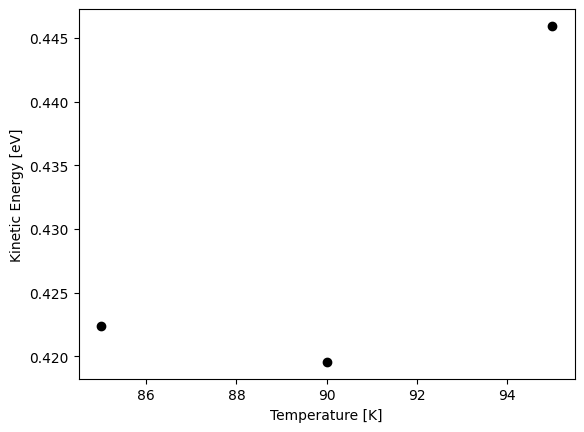

In [11]:

for temp in temperature_list:
    plt.plot(temp,np.mean(np.array(simulation_data[temp]['kin_energy']),axis=1),label=f'T={temp} K',marker='o',color='k')
plt.xlabel('Temperature [K]')  
plt.ylabel('Kinetic Energy [eV]') 

In [12]:
ev_to_joule = 1.602176634e-19  # Conversion factor from eV to Joules
ang_to_m = 1e-10               # Conversion factor from Angstroms to meters
pa_to_bar = 1e-5               # Conversion factor from Pascals to bar

# Value in Å³/eV
angstrom_cubic_per_eV = 0.0002  # Example value

# Convert Å³/eV to bar
pressure_in_pascals = angstrom_cubic_per_eV / ang_to_m**3 * ev_to_joule
pressure_in_bar = pressure_in_pascals * pa_to_bar

for temp in temperature_list:
    pressure=[]
    for pos in tqdm(np.array(simulation_data[temp]['trajectories'][0])):
        # print(quantity.pressure(energy_fn,pos,box_size))
        pressure.append(quantity.pressure(energy_fn,pos,box_size))
    pressure=np.array(pressure)
    print(f"pressure for T ={temp} K is {np.mean(pressure)} in reduced units or {np.mean(pressure)/ang_to_m**3*ev_to_joule*pa_to_bar}bar")

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [01:41<00:00, 19.75it/s]


pressure for T =85 K is -0.0005969332414679229 in reduced units or -956.3924560546875bar


100%|██████████| 2000/2000 [01:39<00:00, 20.13it/s]


pressure for T =90 K is -0.0005088794860057533 in reduced units or -815.3147583007812bar


100%|██████████| 2000/2000 [01:39<00:00, 20.06it/s]


pressure for T =95 K is -0.0004642704443540424 in reduced units or -743.84326171875bar


In [6]:
import pickle

with open('simulation_data.pkl', 'wb') as f:
    pickle.dump(simulation_data, f)